Documentos para estudar:

[Modelos ARIMA](http://leg.ufpr.br/~lucambio/STemporais/STemporaisIII.html)

[Differential transformation method for solving one-space-dimensional telegraph equation
](https://www.scielo.br/j/cam/a/bzWdmhstFXf44DzFgHMyjmK/?lang=en)    

[Sequence classification with LSTM](https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/#sequence-classification-with-lstm)

[Pontuação de variância explicada](https://scikit-learn.org/0.24/modules/model_evaluation.html#regression-metrics)

[Um guia abrangente para iniciantes para criar uma previsão de séries temporais (com códigos em Python e R)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) 

***Pesquisar sobre arquiteruras de Redes Neurais:***

LSTM,
ARIMA

# Previsão de vendas futuras usando Aprendizado de Máquina

In [59]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 602.4 kB/s eta 0:00:00m eta 0:00:010:00:03
Note: you may need to restart the kernel to use updated packages.


In [60]:
# Removendo avisos
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [62]:
# Tratamento e visualização dos dados
import pandas as pd
import numpy as np

import datetime
from pathlib import Path
import random

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

# Modelos Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
#from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [63]:
# Estatistica
from statsmodels.tsa.stattools import adfuller

In [5]:
data_sales = pd.read_csv('train.csv')
df_s = data_sales.copy()
df_s

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
(df_s.isnull().sum()/ df_s.shape[0] * 100).sort_values(ascending=False)

sales    0.0
item     0.0
store    0.0
date     0.0
dtype: float64

In [9]:
df_s['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

In [10]:
#Criando as colunas: ano, mês, semana e dias a partir da coluna 'date'
'''ESSSA CELULÁ ESTÁ COM ERRO, POIS ELA MODIFICA OS DADOS!!!!!!!!!!! RESOLVER'''
df_s['date'] = pd.to_datetime(df_s['date'], format='%Y-%m-%d')

train_df = df_s[df_s['store']==1]
train_df = train_df[df_s['item']==1]

train_df['year'] = df_s['date'].dt.year
train_df['month'] = df_s['date'].dt.month
train_df['day'] = df_s['date'].dt.dayofyear
train_df['weekday'] = df_s['date'].dt.weekday

/tmp/ipykernel_7254/1809322136.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[df_s['item']==1]


In [11]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [12]:
train_df.head(6)

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
5,2013-01-06,1,1,12,2013,1,6,6


In [13]:
def time(data):
    '''Intervalo de tempo do conjunto de dados'''
    
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = int(number_of_days.days / 365)
    
    print(f'Dias: {number_of_days.days}\nAnos: {number_of_years}\nMeses: {12 * number_of_years}')

In [14]:
time(df_s)

Dias: 1825
Anos: 5
Meses: 60


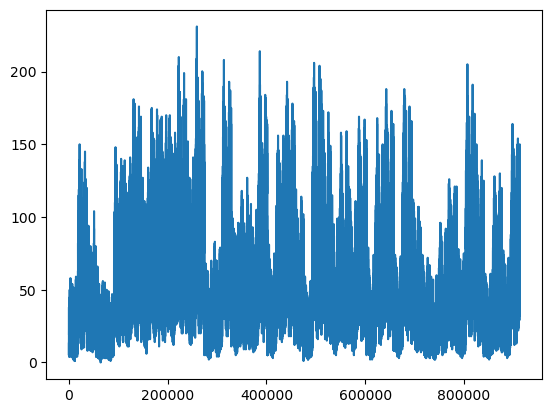

In [15]:
df_s['sales'].plot()

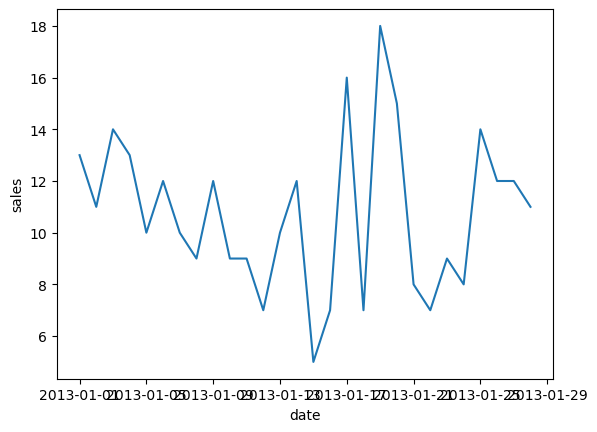

In [16]:
sns.lineplot(x='date', y='sales',legend = 'full' , data=train_df[:28])

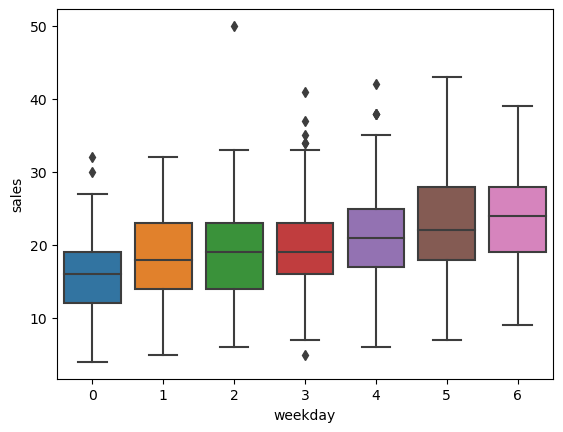

In [17]:
sns.boxplot(x='weekday', y='sales', data=train_df)

Limite de detecção de outliers

Limite inferior: primeiro quartil - 1,5x (terceiro - primeiro quartil)
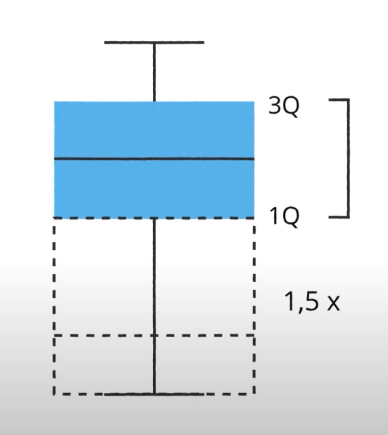

Limite superior: terceiro quartil + 1,5 x (terceiro - primeiro quartil)
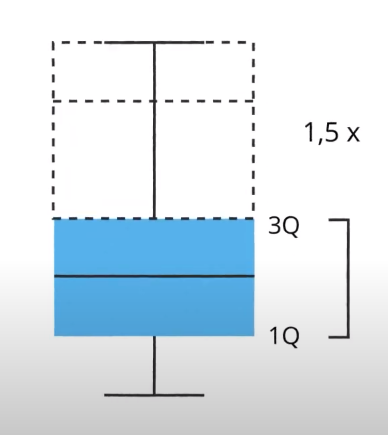

Resumo:4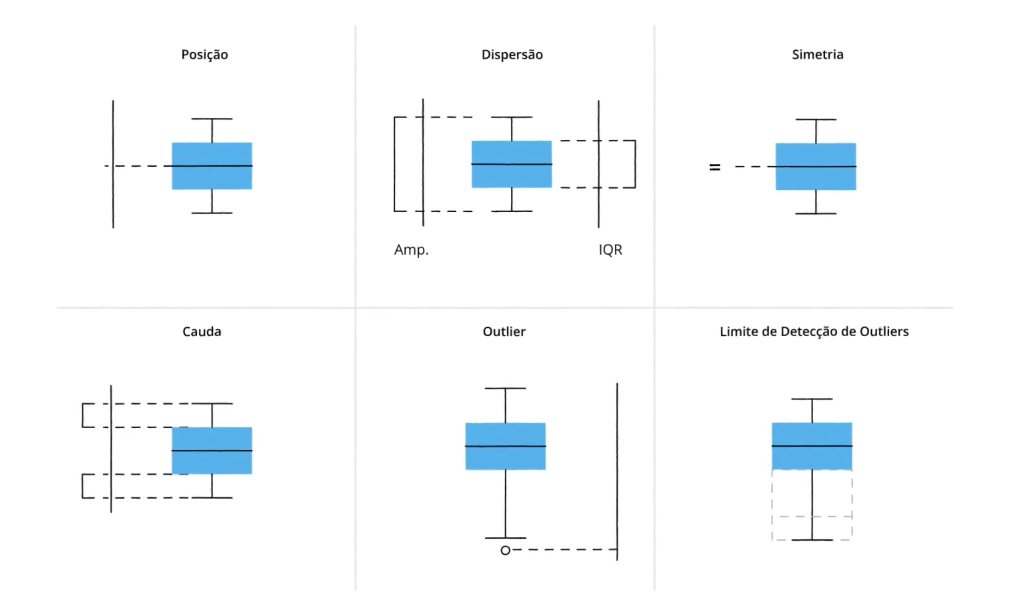

In [89]:
k = 28 / 6
k

4.666666666666667

In [18]:
'''Definição que exclui os indicadores dos dias da coluna (data_sales)
e cria uma nova tabela com a somas de sales por month'''

def month_years_sales(data, time=['monthly','years']):
    data = data.copy()
    if time == 'monthly':
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
    
    return data

In [19]:
df_m = month_years_sales(data_sales, 'monthly')
#df_m.to_csv('./monthly_data.csv')

In [20]:
#Nova tabela mostrando o total de vendas de um determinado mês nas lojas

df_m.head(12)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


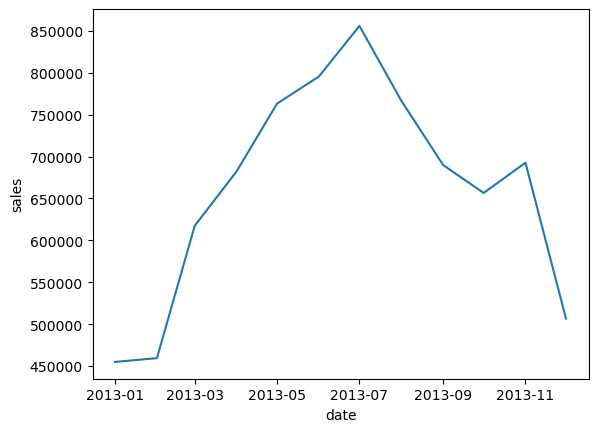

In [21]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=df_m[:12])

In [22]:
df_y = month_years_sales(data_sales, 'years')
df_y

,date,sales
0,2013-01-01,7941243
1,2014-01-01,9135482
2,2015-01-01,9536887
3,2016-01-01,10357160
4,2017-01-01,10733740


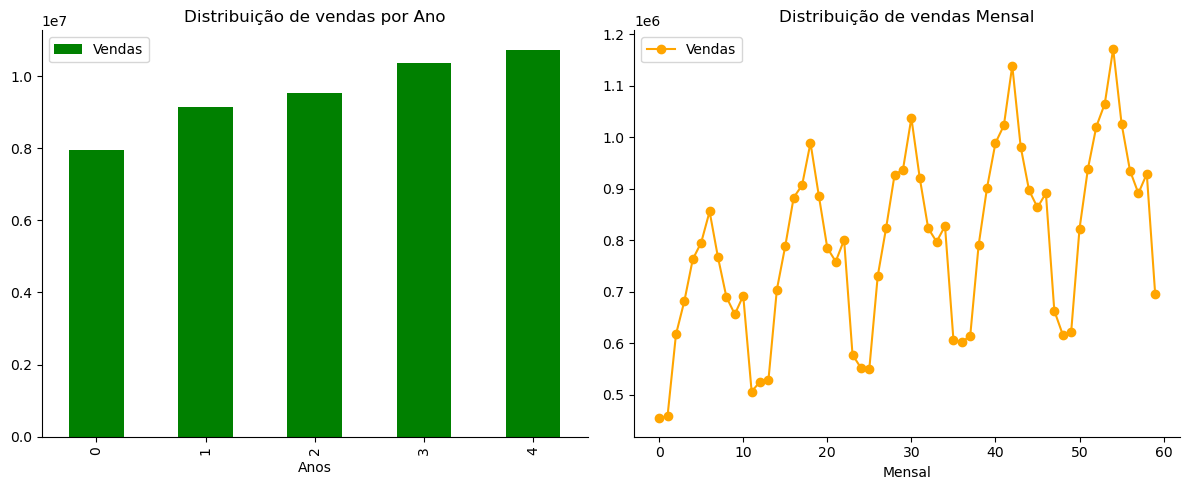

In [23]:
layout = (1,2)

raw = plt.subplot2grid(layout, (0,0))
law = plt.subplot2grid(layout, (0,1))

years = df_y['sales'].plot(kind ='bar', color='green', label='Vendas', ax=raw, figsize=(12,5))
months = df_m['sales'].plot(marker= 'o', color='orange', label='Vendas', ax=law)

years.set(xlabel = 'Anos',title= 'Distribuição de vendas por Ano')
months.set(xlabel = 'Mensal',title= 'Distribuição de vendas Mensal')

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

In [24]:
'''Dados de vendas por loja'''

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkblue')
    
    ax.set(xlabel = "Id Loja", ylabel = 'Soma das Vendas', title = 'Total de vendas por loja')
    
    return sales_by_store

,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


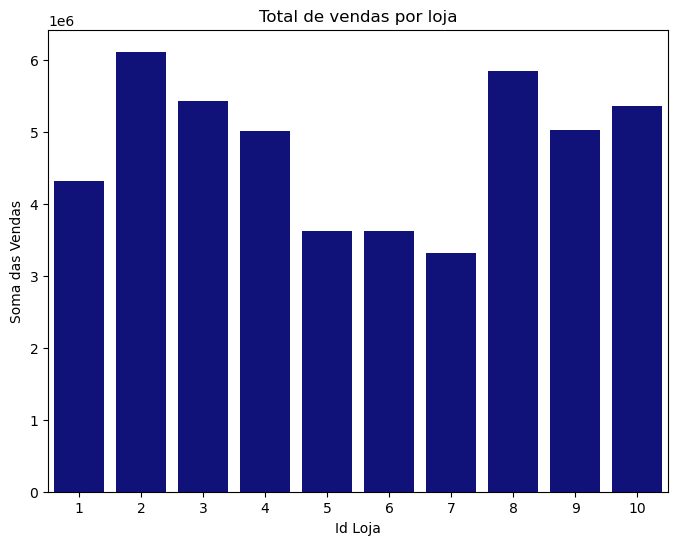

In [25]:
sales_per_store(df_s)

# def abaixo usará Transformação Diferencial como tratamento de Sazonalidade 

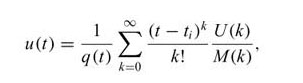

In [26]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x_col, y_col, data = data, ax = ax, color = 'darkblue', label='Total de Vendas')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot((s_mean.date + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Média de Vendas')   
    
    ax.set(xlabel = 'Anos', ylabel = 'Vendas', title = title)

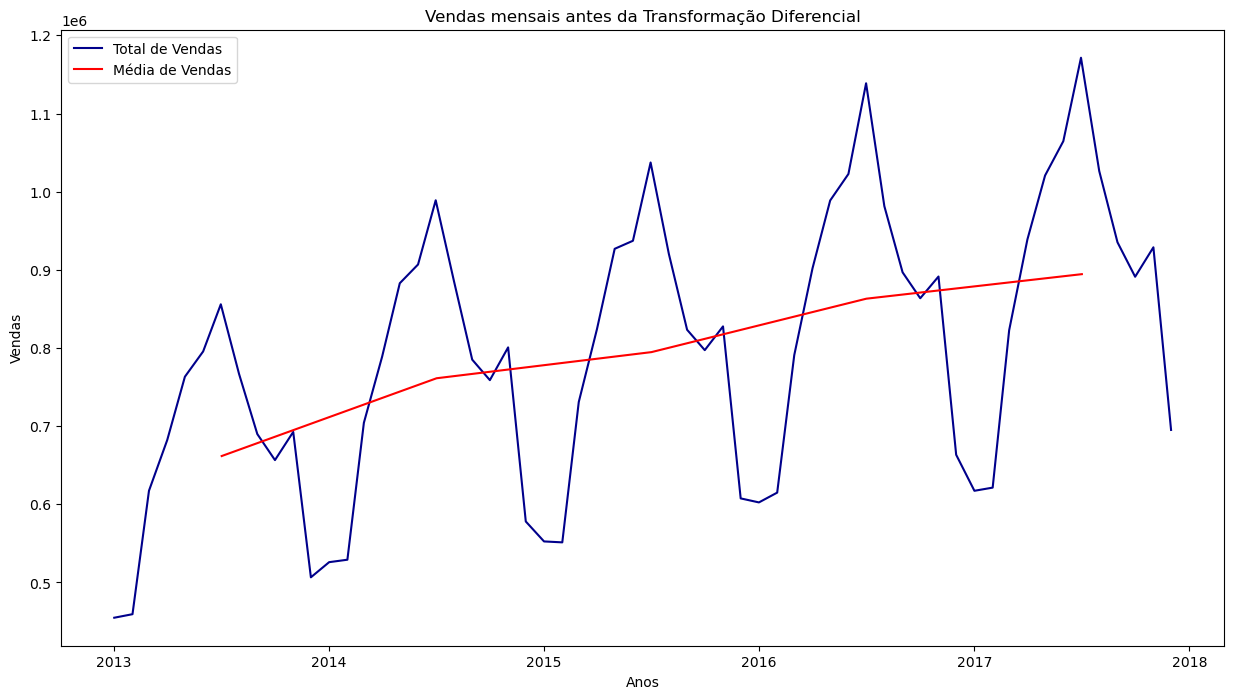

In [27]:
time_plot(df_m, 'date', 'sales', 'Vendas mensais antes da Transformação Diferencial' )

[8.1 Stationarity and differencing](https://otexts.com/fpp2/stationarity.html)

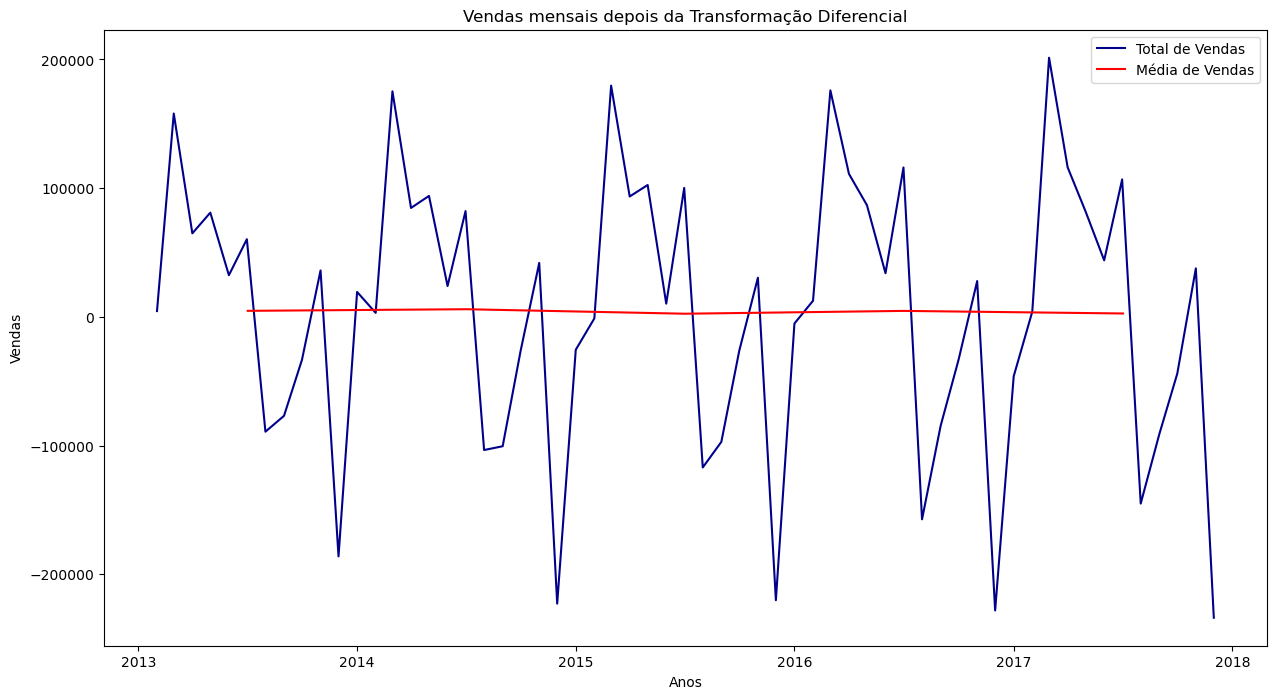

In [28]:
'''Calculo = diferença em vendas mês após mês'''

def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    data.to_csv('./stationary_df.csv')
    return data

stationary_df = get_diff(df_m)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Vendas mensais depois da Transformação Diferencial')

A  equação que representa o cálculo da diferença entre valores consecutivos é a seguinte:

**diff_i = x_i - x_{i-1}**

Nessa equação, diff_i é a diferença entre os valores consecutivos, x_i é o valor da linha atual e x_{i-1} é o valor da linha anterior.

In [29]:
stationary_pd = pd.read_csv('stationary_df.csv')
                            
stationary_pd

,Unnamed: 0,date,sales,sales_diff
0,1,2013-02-01,459417,4513.0
1,2,2013-03-01,617382,157965.0
2,3,2013-04-01,682274,64892.0
3,4,2013-05-01,763242,80968.0
4,5,2013-06-01,795597,32355.0
5,6,2013-07-01,855922,60325.0
6,7,2013-08-01,766761,-89161.0
7,8,2013-09-01,689907,-76854.0
8,9,2013-10-01,656587,-33320.0
9,10,2013-11-01,692643,36056.0


In [39]:
'''Duvida sobre a tabela acima:
    O que deu a entender que Dez/2012
    retornou
    
    Unnamed: 0	date	sales	sales_diff
    0	1	2013-02-01	459417	4513.0
    
    
    ?????
'''

'Duvida sobre a tabela acima:\n    O que deu a entender que Dez/2012\n    retornou\n    \n    Unnamed: 0\tdate\tsales\tsales_diff\n    0\t1\t2013-02-01\t459417\t4513.0\n    \n    \n    ?????\n'

# Modelagem ARIMA

https://towardsdatascience.com/predicting-sales-611cb5a252de

Guia de estudo para aplicações e modelagem de séries temporais com o modelo ARIMA:

***Básico:***

* Entenda o que são séries temporais e por que elas são importantes
* Aprenda a manipular e visualizar séries temporais usando o Pandas
* Entenda os componentes de uma série temporal: tendência, sazonalidade e ruído
* Aprenda a testar a estacionariedade de uma série temporal

***Intermediário:***

* Aprenda a ajustar séries temporais não estacionárias usando diferenciação
* Entenda o que é o modelo ARIMA e como ele pode ser usado para prever séries temporais
* Aprenda a selecionar os melhores parâmetros para o modelo ARIMA usando o processo de seleção de parâmetros
* Aprenda a avaliar o desempenho do modelo ARIMA usando métricas como o RMSE e o MAE
* Aprenda a fazer previsões com o modelo ARIMA usando o Pandas e o statsmodels

***Avançado:***

* Aprenda a tratar séries temporais com sazonalidade não inteira
* Aprenda a tratar séries temporais com tendências não lineares
* Aprenda a fazer previsões a longo prazo com o modelo ARIMA
* Aprenda a integrar o modelo ARIMA com outros modelos de séries temporais, como o modelo SARIMAX
* Aprenda a tratar séries temporais com dados faltantes ou outliers

"Forecasting: Principles and Practice" de Rob J Hyndman e George Athanasopoulos

"Time Series Analysis and Its Applications" de Robert H. Shumway e David S. Stoffer

***CRIAR UM DFT NOVO CONTENDO APENAS UM INDICE DE DATA E HORA E AS COLUNAS DAS VARIAVEIS (DIFF EM VENDAS)***

[Resumo das regras para identificar modelos ARIMA](https://people.duke.edu/~rnau/arimrule.htm)

[statsmodels.graphics.tsaplots.plot_acf](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html)

[Topic 2: Time Series & Autocorrelation
](https://online.stat.psu.edu/stat501/book/export/html/995)

**ACF (Função de Correlação Automática) e (Função de Correlação Automática Parcial)**

  **O que é ACF?**
 
  Por exemplo, o preço das ações de hoje que previmos com base no preço das ações de ontem, o ACF dirá o quanto eles estão correlacionados. .
 
  **O que é PACF?**
 
  Se quisermos calcular a correlação entre hoje e ontem, temos que tomar a correlação de anteontem porque o valor de hoje depende do horário de ontem. Portanto, esta é a razão pela qual usamos o PACF.

   **Modelo PACF-AR**
   
   **Modelo ACF-MA**

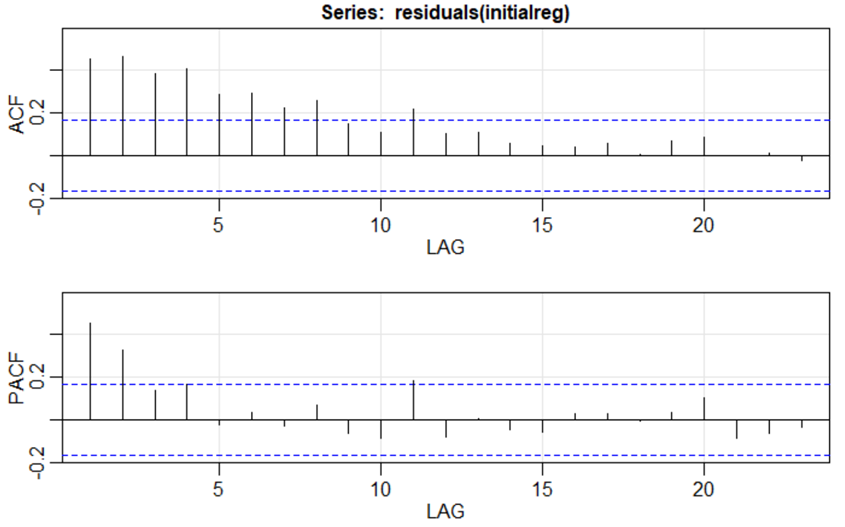

pelas imagens acima podemos observar que, as linhas que cruzam as linhas pontilhadas azuis no PACF e ACF são consideradas como sendo necessários muitos dias para prever o valor de hoje. **Por exemplo, no gráfico PACF acima, que possui apenas três linhas que cruzam as linhas pontilhadas azuis, portanto, os valores dos últimos três dias são necessários para prever o valor de hoje**, da mesma forma o gráfico ACF também, mas para o modelo, não devemos considerar o modelo ACF-MA porque muitas linhas cruzaram a linha limite azul, então isso criará o complexo do modelo. Portanto, devemos selecionar apenas o modelo PACF-AR para prever

In [65]:
'''def build_arima_data(data):
    pegar apenas a data, dropar a columns "sales"
    dropar valores nulos das linhas
    retornar data'''

'def build_arima_data(data):\n    pegar apenas a data, dropar a columns "sales"\n    dropar valores nulos das linhas\n    retornar data'

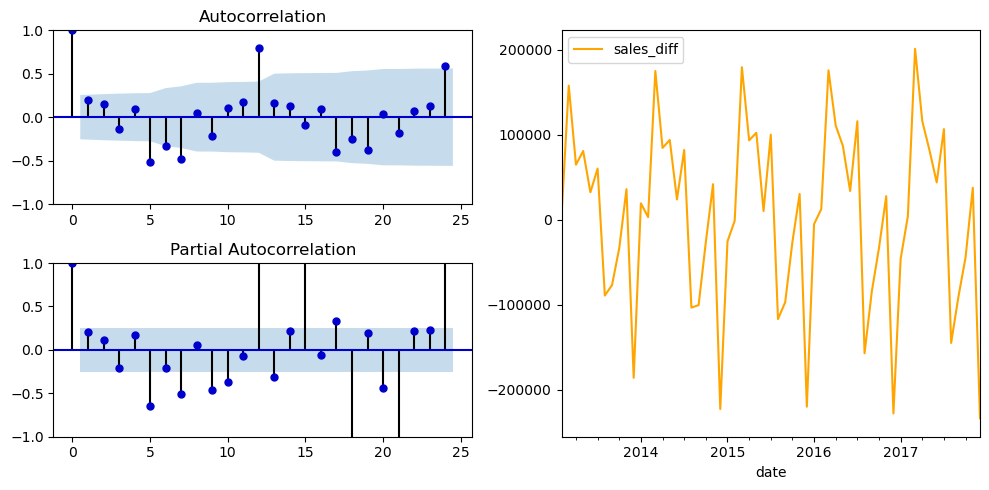

In [66]:
def plots_lag(data, lags=None):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(10, 5), color='orange')
    # Aqui será gerado o gráfico da autocorrelação
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    
    #  ajustará o espaçamento entre subquadrantes para minimizar as sobreposições
    plt.tight_layout()

plots_lag(stationary_df, lags=24);

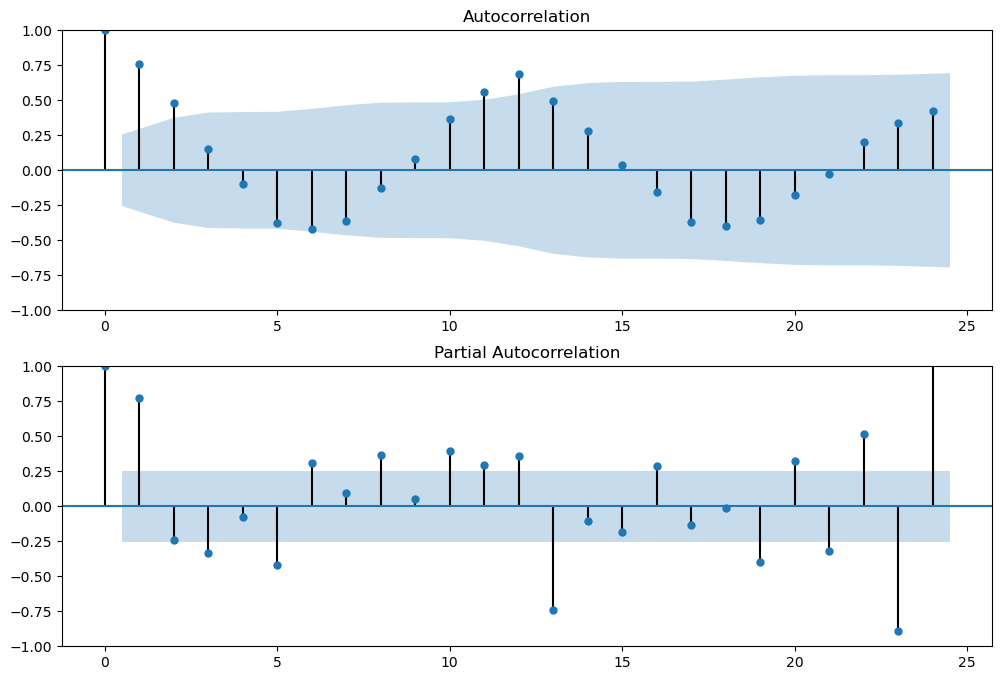

In [67]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stationary_df.sales, lags=24, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stationary_df.sales, lags=24, ax=ax2)


In [45]:
#arima_mod6 = sm.tsa.ARIMA(stationary_df.sales, (6,1,0)).fit(disp=False)

# Modelagem Regressiva

In [46]:
def built_supervised(data):
    supervised_df = data.copy()

    # Criar coluna para cada atraso (1 a 12)
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Remove os valores nulos
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df

In [68]:
model = built_supervised(stationary_df)
model

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [69]:
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        47 non-null     datetime64[ns]
 1   sales       47 non-null     int64         
 2   sales_diff  47 non-null     float64       
 3   lag_1       47 non-null     float64       
 4   lag_2       47 non-null     float64       
 5   lag_3       47 non-null     float64       
 6   lag_4       47 non-null     float64       
 7   lag_5       47 non-null     float64       
 8   lag_6       47 non-null     float64       
 9   lag_7       47 non-null     float64       
 10  lag_8       47 non-null     float64       
 11  lag_9       47 non-null     float64       
 12  lag_10      47 non-null     float64       
 13  lag_11      47 non-null     float64       
 14  lag_12      47 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 5.6 KB


# Como será a modelagem?

Para criar e avaliar todos os nossos modelos, utilizaremos uma série de funções de ajuda que desempenham as seguintes funções:

* Treine a divisão do teste
* Dimensionar os dados
* Escala reversa
* Criar um quadro de dados de previsão
* Pontue os modelos


# Divisão do teste de treinamento

Destacamos os nossos dados para que os últimos 12 meses façam parte do conjunto de testes e o resto dos dados seja utilizado para treinar o nosso modelo.

In [70]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-12].values, data[-12:].values
    
    return train, test

In [71]:
train, test = train_test_split(model)

print(f'Treinamento: {train.shape}\nTeste: {test.shape}')

Treinamento: (35, 13)
Teste: (12, 13)


# Dimensionar os dados

Utilizando um escalador min-max **[from sklearn.model_selection import train_test_split
]**, escalaremos os dados de modo a que todas as nossas variáveis fiquem dentro do intervalo de -1 a 1.

In [74]:
def scale_data(train_set,test_set):
    '''Escala dados usando o MinMaxScaler e separa dados em X_train, y_train,
    X_test, and y_test.'''
    
    # Aplicação Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reformular o conjunto de treino
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reformular o conjunto de teste
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # devolve a matriz aplanada
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f'Corpo do X Train: {X_train.shape}\nCorpo do y Train: {y_train.shape}\nCorpo do X Test: {X_test.shape}\nCorpo do y Test: {y_test.shape}')

Corpo do X Train: (35, 12)
Corpo do y Train: (35,)
Corpo do X Test: (12, 12)
Corpo do y Test: (12,)


# Escala Reversa

In [75]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    '''Para visualizar e comparar resultados, desfaz o efeito de escala sobre as previsões'''
    '''   
    y_pred: previsões do modelo
    x_test: características do conjunto de teste utilizadas para previsões
    scaler_obj: os objectos scaler usados para escalar min-max
    lstm: indicar se a execução do modelo é a lstm. Se Verdadeiro, ocorre transformação adicional 
    '''
    
    # Reformular y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Conjunto de teste de reconstrução para transformação inversa:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reconstrução pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Transformação Inversa
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted
    


# Criação de um quadro de dados de previsão

Gerar um quadro de dados que inclua as vendas reais capturadas no nosso conjunto de testes e os resultados previstos do nosso modelo, para que possamos quantificar o nosso sucesso.

In [76]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original monthly sales dataframe
    
    # Create dataframe that shows the predicted sales:
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

# Pontuação dos Modelos

Esta função de ajuda salvará o erro médio quadrático (RMSE) e o erro médio absoluto (MAE) das nossas previsões para comparar o desempenho dos nossos modelos.
[Regression Metrics](https://scikit-learn.org/0.24/modules/model_evaluation.html#regression-metrics)

Para visualizar a precisão do seu modelo de regressão, um bom primeiro passo é plotar os dados reais e os dados previstos juntos em um gráfico. Isso permitirá que você veja visualmente como o modelo está se saindo em relação aos dados reais.

Uma vez que você tenha plotado os dados reais e previstos, você pode calcular algumas métricas de precisão para avaliar o desempenho do seu modelo. Algumas métricas comuns incluem:

* Erro quadrático médio (MSE): A raiz quadrada da média dos erros ao quadrado
* Erro absoluto médio (MAE): A média dos erros absolutos
* R-quadrado: Uma medida de quão bem os dados se ajustam ao modelo, com valores que variam de 0 a 1


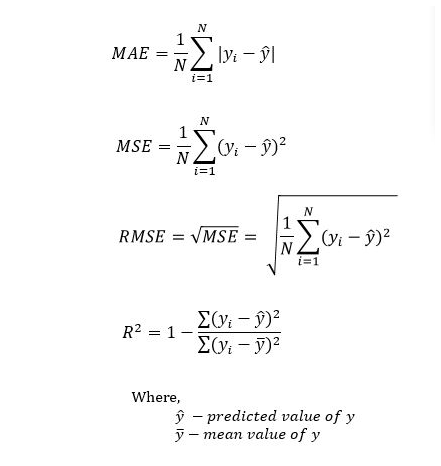

In [77]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    '''
      Imprime a raiz erro médio ao quadrado, erro médio absoluto, e pontuações r2
    para cada modelo. Guarda todos os resultados num dicionário de pontuação_modelo para
    comparação.
    '''
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.sales[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.sales[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

# Gráfico dos Resultados

In [84]:
def plot_results(results, origin_df, model_name):
    '''um quadro de dados com previsões não escalonadas'''
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(origin_df.date, origin_df.sales, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend(loc='best')
    
    filepath = Path('./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./model_output/{model_name}_forecasting.svg')

In [85]:
def regressive_model(train_data, test_data, model, model_name):
    '''Executa modelos regressivos no quadro do SKlearn.
    Primeiras chamadas escala_dados para dividir em X e y e escalar os dados.
    Depois encaixa e prevê. Finalmente, as previsões não são escalonadas, as partituras são impressas,
    e os resultados são traçados e guardado'''
    
    # Dividir em X & y e escalar os dados:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Executa sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Desfazer escalas para comparar previsões com dados originais:
    origin_df = df_m
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Imprime os valores e constroe os resultados
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)

# Plot usando XGBoost

O RMSE (Root Mean Squared Error, ou Erro Quadrático Médio) é uma medida da distância média entre os valores previstos pelo seu modelo e os valores reais. Ele é calculado como a raiz quadrada da média dos erros ao quadrado. O RMSE é útil porque ele leva em conta a magnitude dos erros, de modo que erros maiores têm um maior impacto no resultado final.

O MAE (Mean Absolute Error, ou Erro Absoluto Médio) é uma medida da distância média entre os valores previstos pelo seu modelo e os valores reais. Ele é calculado como a média dos erros absolutos. O MAE é útil porque ele não leva em conta a magnitude dos erros, de modo que erros maiores não têm um impacto maior no resultado final.

O R-quadrado (R2 Score) é uma medida de quão bem os dados se ajustam ao modelo e é dado por um valor que varia de 0 a 1. Quanto maior o R-quadrado, melhor o ajuste do modelo aos dados. No seu caso, o R-quadrado é de 0,993497694881536, o que indica um bom ajuste do modelo aos dados.



RMSE: 13574.854581787116
MAE: 11649.75
R2 Score: 0.993497694881536


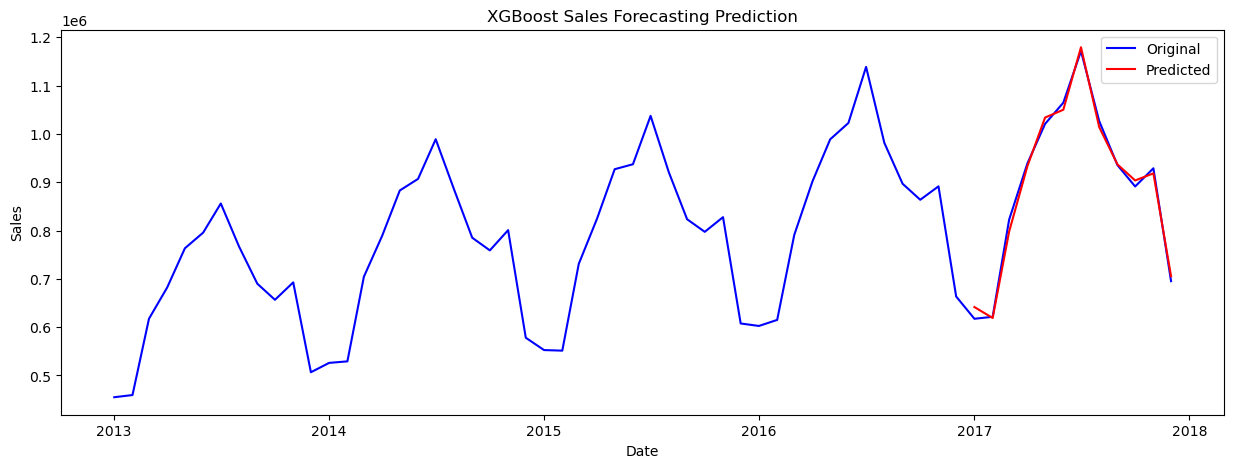

In [83]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')